# Federated Learning

This notebook simulates a federated learning environment. It begins by sending initial weights from a central party to a client. The client then trains a `LogisticRegression` model and returns updated weights to the central party. The central party applies a simple aggregation mechanism and stores the updated weights in the file `/model/params.json`. This allows us to read and visualize the model parameters at each iteration and trigger new learning iterations.

In [1]:
import json
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

sys.path.append(os.path.join(os.getcwd(), "..", "src", "lib"))
from api import create_invitation, receive_invitation, send_message, get_connection

CENTRAL_PARTY_ADMIN_URL = "http://localhost:8001"
FL_CLIENT_ADMIN_URL = "http://localhost:8101"

In [2]:
print("Central Party: Creating invitation...")
central_party_invitation = create_invitation(CENTRAL_PARTY_ADMIN_URL)
print("Central Party's invitation:", json.dumps(central_party_invitation, indent=2))

Central Party: Creating invitation...
Central Party's invitation: {
  "connection_id": "66b622ab-01ef-4c96-86de-e37f2507340f",
  "invitation": {
    "@type": "did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation",
    "@id": "ae92f34e-05ca-44af-9299-b2c46996ffd2",
    "label": "Central Party Agent",
    "serviceEndpoint": "http://central-party-agent:8000",
    "recipientKeys": [
      "EayQ3qcE1xUm1oEo35dB1d8sj5S1JWgYhZuyHdHBM4VW"
    ]
  },
  "invitation_url": "http://central-party-agent:8000?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiYWU5MmYzNGUtMDVjYS00NGFmLTkyOTktYjJjNDY5OTZmZmQyIiwgImxhYmVsIjogIkNlbnRyYWwgUGFydHkgQWdlbnQiLCAic2VydmljZUVuZHBvaW50IjogImh0dHA6Ly9jZW50cmFsLXBhcnR5LWFnZW50OjgwMDAiLCAicmVjaXBpZW50S2V5cyI6IFsiRWF5UTNxY0UxeFVtMW9FbzM1ZEIxZDhzajVTMUpXZ1loWnV5SGRIQk00VlciXX0="
}


In [3]:
print("FL Client: Receiving invitation...")
fl_client_connection = receive_invitation(
    FL_CLIENT_ADMIN_URL, central_party_invitation["invitation"]
)
print("FL Client's connection:", json.dumps(fl_client_connection, indent=2))

FL Client: Receiving invitation...
FL Client's connection: {
  "invitation_msg_id": "ae92f34e-05ca-44af-9299-b2c46996ffd2",
  "my_did": "9YEm3GVNtzhxX2B6tmdBgY",
  "request_id": "fd062b15-af84-4777-96ff-a0fadbab4989",
  "invitation_mode": "once",
  "state": "request",
  "created_at": "2024-07-09 04:07:57.929364Z",
  "connection_protocol": "connections/1.0",
  "connection_id": "e90751ae-cb29-408c-8014-486e42f700c0",
  "updated_at": "2024-07-09 04:07:57.931429Z",
  "their_label": "Central Party Agent",
  "invitation_key": "EayQ3qcE1xUm1oEo35dB1d8sj5S1JWgYhZuyHdHBM4VW",
  "routing_state": "none",
  "accept": "auto",
  "rfc23_state": "request-sent",
  "their_role": "inviter"
}


In [4]:
fl_client_connection_id = fl_client_connection["connection_id"]
fl_client_connection = get_connection(FL_CLIENT_ADMIN_URL, fl_client_connection_id)
print(
    "FL Client's connection status:",
    json.dumps(fl_client_connection["state"], indent=2),
)

central_party_connection_id = central_party_invitation["connection_id"]
central_party_connection = get_connection(
    CENTRAL_PARTY_ADMIN_URL, central_party_connection_id
)
print(
    "Central Party's connection status:",
    json.dumps(central_party_connection["state"], indent=2),
)

FL Client's connection status: "request"
Central Party's connection status: "response"


In [5]:
model_params = {"coef": None, "intercept": None}
json_str = json.dumps(model_params)
json_bytes = json_str.encode("utf-8")
hex_str = json_bytes.hex()

In [6]:
print("Initiate FL training run by sending initial weights to client.")
message_response = send_message(
    CENTRAL_PARTY_ADMIN_URL, central_party_connection_id, hex_str
)
print("Message response:", json.dumps(message_response, indent=2))

Initiate FL training run by sending initial weights to client.
Message response: {}


In [7]:
iterations = list(range(1, 18))
accs = []
macro_f1 = []
micro_f1 = []

time.sleep(10)
for i in iterations:
    print(f"Iteration Number {i + 1}")
    with open("../model/params.json", "r") as file:
        model_params = json.load(file)

    model = LogisticRegression(max_iter=1000)
    model.coef_ = np.array(model_params["coef"])
    model.intercept_ = np.array(model_params["intercept"])
    model.classes_ = np.array([0, 1])

    df_test = pd.read_csv("../data/titanic_test.csv")
    X_test = df_test.drop("Survived", axis=1)
    y_test = df_test["Survived"]

    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    acc = report["accuracy"]
    print(f"Accuracy: {acc}")
    accs.append(acc)
    macro_f1.append(report["macro avg"]["f1-score"])
    micro_f1.append(report["weighted avg"]["f1-score"])

    json_str = json.dumps(model_params)
    json_bytes = json_str.encode("utf-8")
    hex_str = json_bytes.hex()

    message_response = send_message(
        CENTRAL_PARTY_ADMIN_URL, central_party_connection_id, hex_str
    )
    print(20 * "-")

Iteration Number 2
Accuracy: 0.7206703910614525
--------------------
Iteration Number 3
Accuracy: 0.7206703910614525
--------------------
Iteration Number 4
Accuracy: 0.7206703910614525
--------------------
Iteration Number 5
Accuracy: 0.7486033519553073
--------------------
Iteration Number 6
Accuracy: 0.7486033519553073
--------------------
Iteration Number 7
Accuracy: 0.7430167597765364
--------------------
Iteration Number 8
Accuracy: 0.7430167597765364
--------------------
Iteration Number 9
Accuracy: 0.7374301675977654
--------------------
Iteration Number 10
Accuracy: 0.7374301675977654
--------------------
Iteration Number 11
Accuracy: 0.7374301675977654
--------------------
Iteration Number 12
Accuracy: 0.7374301675977654
--------------------
Iteration Number 13
Accuracy: 0.770949720670391


/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: Us

--------------------
Iteration Number 14
Accuracy: 0.7374301675977654
--------------------
Iteration Number 15
Accuracy: 0.7374301675977654
--------------------
Iteration Number 16
Accuracy: 0.7374301675977654
--------------------
Iteration Number 17
Accuracy: 0.7374301675977654
--------------------
Iteration Number 18
Accuracy: 0.7374301675977654
--------------------


/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lukas/.local/share/virtualenvs/didcomm-playground-YubQGKyV/lib/python3.8/site-packages/sklearn/base.py:458: Us

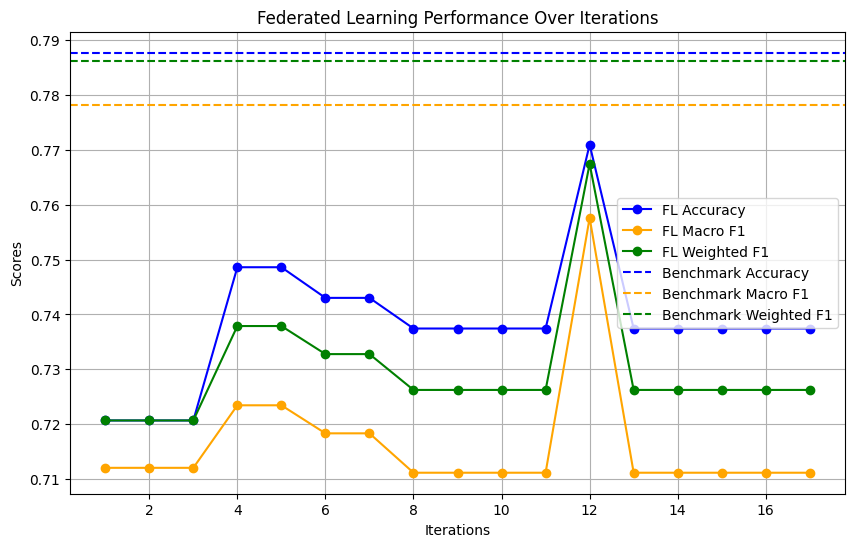

In [8]:
benchmark_acc, benchmark_macro_f1, benchmark_micro_f1 = (
    0.7877094972067039,
    0.7782342201356287,
    0.7861729657897729,
)

plt.figure(figsize=(10, 6))
plt.plot(iterations, accs, label="FL Accuracy", marker="o", color="blue")
plt.plot(iterations, macro_f1, label="FL Macro F1", marker="o", color="orange")
plt.plot(iterations, micro_f1, label="FL Weighted F1", marker="o", color="green")

# Plot benchmark scores
plt.axhline(y=benchmark_acc, color="blue", linestyle="--", label="Benchmark Accuracy")
plt.axhline(
    y=benchmark_macro_f1, color="orange", linestyle="--", label="Benchmark Macro F1"
)
plt.axhline(
    y=benchmark_micro_f1, color="green", linestyle="--", label="Benchmark Weighted F1"
)

plt.xlabel("Iterations")
plt.ylabel("Scores")
plt.title("Federated Learning Performance Over Iterations")
plt.legend()
plt.grid(True)
plt.show()